Step 1 : Installing the required Libraries

In [1]:
!pip install tensorflow opencv-python numpy matplotlib

Step 2 : Importing the required libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from google.colab import files

Step 3 : Download The Dataset

Here we are using "Face Mask Detection Dataset" from Github.

In [3]:
!wget --no-check-certificate \
    "https://github.com/chandrikadeb7/Face-Mask-Detection/archive/refs/heads/master.zip" \
    -O face_mask_dataset.zip

# Unzipping the dataset
with zipfile.ZipFile("face_mask_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("face_mask_data")

--2025-02-10 16:18:47--  https://github.com/chandrikadeb7/Face-Mask-Detection/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/chandrikadeb7/Face-Mask-Detection/zip/refs/heads/master [following]
--2025-02-10 16:18:48--  https://codeload.github.com/chandrikadeb7/Face-Mask-Detection/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.116.9
Connecting to codeload.github.com (codeload.github.com)|140.82.116.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘face_mask_dataset.zip’

face_mask_dataset.z     [  <=>               ] 190.46M  25.3MB/s    in 7.5s    

2025-02-10 16:18:55 (25.5 MB/s) - ‘face_mask_dataset.zip’ saved [199714088]



Step 4 : Data Preprocessing

In [5]:
import os

# Check the extracted folder structure
extracted_path = "face_mask_data/Face-Mask-Detection-master"
print("Contents of the dataset folder:", os.listdir(extracted_path))

Contents of the dataset folder: ['README.md', 'dataset', 'train_mask_detector.py', 'images', 'detect_mask_video.py', '_config.yml', 'incep_v3_mask_model', 'ResNet50_v2', 'detect_mask_image.py', 'Readme_images', 'plot.png', '__pycache__', 'CODE_OF_CONDUCT.md', 'face_detector', 'CONTRIBUTING.md', '.github', 'search.py', 'mask_detector.model', 'Windows_guide.md', 'LICENSE', 'CITATION.cff', 'model2onnx.py', '.gitignore', '.DS_Store', 'README - Korean.md', 'Logo', 'app.py', 'requirements.txt', 'css']


In [6]:
dataset_path = os.path.join(extracted_path, "dataset")
print("Contents of dataset:", os.listdir(dataset_path))

Contents of dataset: ['without_mask', 'with_mask']


In [10]:
train_dir = "face_mask_data/Face-Mask-Detection-master/dataset"
test_dir = "face_mask_data/Face-Mask-Detection-master/dataset"

In [11]:
print(f"Train Images: {len(os.listdir(train_dir + '/with_mask')) + len(os.listdir(train_dir + '/without_mask'))}")
print(f"Test Images: {len(os.listdir(test_dir + '/with_mask')) + len(os.listdir(test_dir + '/without_mask'))}")

Train Images: 4095
Test Images: 4095


Step 5 : Data Augmentation

We will apply augmentation to prevent overfitting.

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary"
)

Found 4092 images belonging to 2 classes.
Found 4092 images belonging to 2 classes.


Step 6 : Building the CNN Model

In [13]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (Mask vs No Mask)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

# Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Step 7 : Training the Model.

In [14]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 54/128 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - accuracy: 0.5468 - loss: 0.9221

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 278ms/step - accuracy: 0.6411 - loss: 0.7347 - val_accuracy: 0.8744 - val_loss: 0.3162
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 254ms/step - accuracy: 0.8402 - loss: 0.3691 - val_accuracy: 0.9125 - val_loss: 0.2287
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 248ms/step - accuracy: 0.8619 - loss: 0.3518 - val_accuracy: 0.9176 - val_loss: 0.2219
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 33s 256ms/step - accuracy: 0.8727 - loss: 0.3127 - val_accuracy: 0.9313 - val_loss: 0.1905
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 247ms/step - accuracy: 0.8791 - loss: 0.2973 - val_accuracy: 0.9206 - val_loss: 0.2170
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 34s 263ms/step - accuracy: 0.8920 - loss: 0.2736 - val_accuracy: 0.9176 - val_loss: 0.2175
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 248ms/step - accuracy: 0.8970 - loss: 0.2656 - val_accuracy: 0.9296 - val_loss: 0.1808
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 253ms/step - accuracy: 0.8875 - loss: 0.2809 - val

Step 8 : Evaluating the Model.

In [15]:
# Evaluate on test data
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy*100:.2f}%")

128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9391 - loss: 0.1582
Test Accuracy: 93.96%


Step 9 : Visualizing the Training Results.

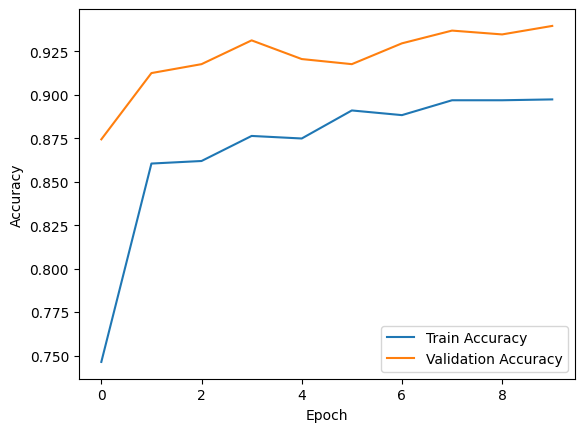

In [16]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Step 10 : Testing with my own Image.

Saving 20230309_155523.jpg to 20230309_155523.jpg
Saving 20230309_173034.jpg to 20230309_173034 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


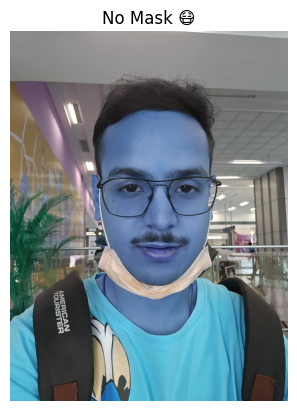

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


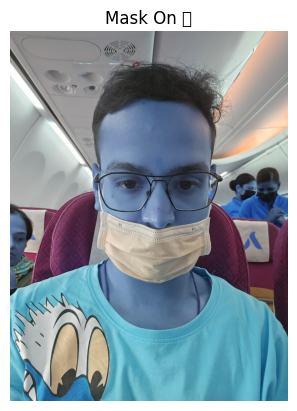

In [18]:
uploaded = files.upload()

for filename in uploaded.keys():
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = np.expand_dims(img, axis=0) / 255.0

    prediction = model.predict(img)[0][0]

    if prediction > 0.5:
        label = "No Mask 😷"
    else:
        label = "Mask On ✅"

    plt.imshow(cv2.imread(filename))
    plt.title(label)
    plt.axis("off")
    plt.show()